In [119]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.occ import *
from xfem import *
import pyvista as pv
from IPython.display import Image, display

In [120]:
shape = Rectangle(1.0, 1.0).Face()
shape.edges.Max(X).name = "right"
shape.edges.Min(X).name = "left"
shape.edges.Max(Y).name = "top"
shape.edges.Min(Y).name = "bottom"
mesh = Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.01))

In [121]:
levelset = (sqrt((x-0.5)**2 + (y-0.5)**2) - 0.375)
DrawDC(levelset, -3.5, 2.5, mesh, "levelset")

# Piecewise-linear approximation of the level set used by CutFEM
lsetp1 = GridFunction(H1(mesh, order=1))
InterpolateToP1(levelset, lsetp1)

# Cut info (tells which elements are NEG/POS/cut by the interface)
ci = CutInfo(mesh, lsetp1)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

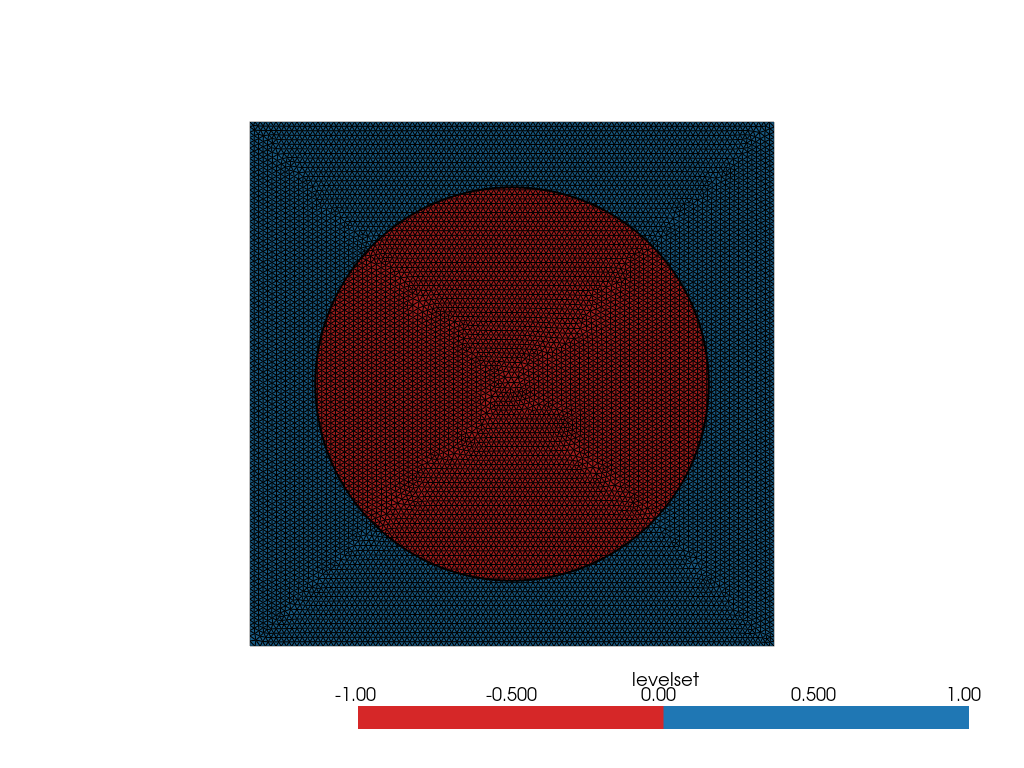

In [122]:
vtk = VTKOutput(mesh, coefs=[levelset], names=["levelset"], filename="levelset_2").Do()
vis = pv.read("levelset_2.vtu")


cont = vis.contour(isosurfaces=[0], scalars="levelset")
pl = pv.Plotter()
pl.add_mesh(vis, scalars="levelset",
            cmap=["#d62728", "#1f77b4"], clim=[-1,1],
            categories=True, show_edges=True)
pl.add_mesh(cont, color="black", line_width=2)
pl.camera_position = "xy"
pl.screenshot("levelset_2.png")
pl.close()
display(Image(filename="levelset_2.png"))

In [123]:
E_in,  nu_in  = 3.0, 0.30   # phi<0 (inside disk)
E_out, nu_out = 1.0, 0.20   # phi>0 (outside)

plane_stress = False

def lame_from_Enu(E, nu, plane_stress=False):
    mu = E/(2*(1+nu))
    lam = E*nu/((1+nu)*(1-2*nu))          # 3D Lamé
    lam_eff = (2*mu*nu/(1-nu)) if plane_stress else lam
    return mu, lam_eff

mu = [] ; lam_eff = []
mu.append( lame_from_Enu(E_in,  nu_in,  plane_stress)[0] ); lam_eff.append( lame_from_Enu(E_in,  nu_in,  plane_stress)[1] )
mu.append( lame_from_Enu(E_out, nu_out, plane_stress)[0] ); lam_eff.append( lame_from_Enu(E_out, nu_out, plane_stress)[1] )


In [124]:
# component-wise Dirichlet (same as your original Vx/Vy idea)
Vx = H1(mesh, order=2, dirichlet="left")    # fixes ux only on 'left'
Vy = H1(mesh, order=2, dirichlet="bottom")  # fixes uy only on 'bottom'
X  = Vx * Vy
Vcut = FESpace([X, X])   # 0: Ω-, 1: Ω+

# trial/test with explicit components per side
((ux_neg, uy_neg), (ux_pos, uy_pos)), ((vx_neg, vy_neg), (vx_pos, vy_pos)) = Vcut.TnT()

u_neg = CoefficientFunction((ux_neg, uy_neg))
u_pos = CoefficientFunction((ux_pos, uy_pos))
v_neg = CoefficientFunction((vx_neg, vy_neg))
v_pos = CoefficientFunction((vx_pos, vy_pos))

freedofs = Vcut.FreeDofs()
freedofs &= CompoundBitArray([
    GetDofsOfElements(X, ci.GetElementsOfType(HASNEG)),
    GetDofsOfElements(X, ci.GetElementsOfType(HASPOS))
])


In [125]:
Id2 = Id(2)

def eps(ux, uy):
    exx = grad(ux)[0]
    eyy = grad(uy)[1]
    exy = 0.5*(grad(ux)[1] + grad(uy)[0])
    return CoefficientFunction((exx, exy,
                                exy, eyy), dims=(2,2))

def sigma(ux, uy, mu_, lam_eff_):
    e  = eps(ux, uy)
    tr = e[0,0] + e[1,1]
    return 2*mu_*e + lam_eff_*tr*Id2


In [126]:
h = specialcf.mesh_size
n = Normalize(grad(lsetp1))

# restrict integration to cells where it matters (faster)
dx_neg = dCut(levelset=lsetp1, domain_type=NEG, definedonelements=ci.GetElementsOfType(HASNEG))
dx_pos = dCut(levelset=lsetp1, domain_type=POS, definedonelements=ci.GetElementsOfType(HASPOS))
# interface measure (Gamma)
ds_if  = dCut(levelset=lsetp1, domain_type=IF,  definedonelements=ci.GetElementsOfType(IF))

# Hansbo cut ratio for weighted averages on Gamma
kappaminus = CutRatioGF(ci)     # kappa_- = |T∩Omega_-|/|T|
kappa = (kappaminus, 1-kappaminus)

# average traction and displacement jumps
avg_tr_u = -kappa[0] * (sigma(ux_neg, uy_neg, mu[0], lam_eff[0]) * n) \
           -kappa[1] * (sigma(ux_pos, uy_pos, mu[1], lam_eff[1]) * n)
avg_tr_v = -kappa[0] * (sigma(vx_neg, vy_neg, mu[0], lam_eff[0]) * n) \
           -kappa[1] * (sigma(vx_pos, vy_pos, mu[1], lam_eff[1]) * n)

jump_u = CoefficientFunction((ux_neg - ux_pos, uy_neg - uy_pos))
jump_v = CoefficientFunction((vx_neg - vx_pos, vy_neg - vy_pos))

# Nitsche penalty (use material scale ~ 2*mu + lam)
alpha_minus = 2*mu[0] + lam_eff[0]
alpha_plus  = 2*mu[1] + lam_eff[1]
alpha_bar   = 0.5*(alpha_minus + alpha_plus)
penalty     = 20*alpha_bar/h

In [127]:
A = BilinearForm(Vcut, symmetric=True)
# subdomain contributions
A += InnerProduct(sigma(ux_neg, uy_neg, mu[0], lam_eff[0]), eps(vx_neg, vy_neg)) * dx_neg
A += InnerProduct(sigma(ux_pos, uy_pos, mu[1], lam_eff[1]), eps(vx_pos, vy_pos)) * dx_pos
# interface terms: consistency + symmetry + penalty
A += ( InnerProduct(avg_tr_u, jump_v)
     + InnerProduct(avg_tr_v, jump_u)
     + penalty * InnerProduct(jump_u, jump_v) ) * ds_if

# external traction on right boundary (apply to both sides consistently)
# (only acts where the background boundary is present; interface is interior)
F = LinearForm(Vcut)
traction = CoefficientFunction((1.0, 0.0))
F += InnerProduct(traction, CoefficientFunction((vx_neg, vy_neg))) * ds("right")
F += InnerProduct(traction, CoefficientFunction((vx_pos, vy_pos))) * ds("right")

In [128]:
with TaskManager():
    A.Assemble(); F.Assemble()
    gfu = GridFunction(Vcut)
    gfu.vec.data = A.mat.Inverse(freedofs) * F.vec

ux_neg, uy_neg = gfu.components[0].components   # phi<0 side
ux_pos, uy_pos = gfu.components[1].components   # phi>0 side

u_neg = CoefficientFunction((ux_neg, uy_neg))
u_pos = CoefficientFunction((ux_pos, uy_pos))

# IfPos chooses the FIRST arg when lsetp1 > 0 (outside for your distance - R)
uh = IfPos(lsetp1, u_pos, u_neg)
norm_u = Norm(uh)
Draw(norm_u, mesh, "||u||")

def sigma_2D_param(ux, uy, mu_loc, lam_eff_loc):
    exx = grad(ux)[0]
    eyy = grad(uy)[1]
    exy = 0.5*(grad(ux)[1] + grad(uy)[0])
    e = CoefficientFunction((exx, exy, exy, eyy), dims=(2,2))
    tr = exx + eyy
    return 2*mu_loc*e + lam_eff_loc*tr*Id(2)


# per‑phase stresses
s_neg = sigma_2D_param(ux_neg, uy_neg, mu[0], lam_eff[0])
s_pos = sigma_2D_param(ux_pos, uy_pos, mu[1], lam_eff[1])

# piecewise stress field (matrix IfPos works elementwise)
s   = IfPos(lsetp1, s_pos, s_neg)

# von Mises (2D plane strain/stress)
von_mises = sqrt(s[0,0]**2 + s[1,1]**2 - s[0,0]*s[1,1] + 3*s[0,1]**2)
Draw(von_mises, mesh, "von Mises")#, deformation=uh)

print("ndof(-)", Vcut.components[0].ndof, " ndof(+)", Vcut.components[1].ndof)


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

ndof(-) 93498  ndof(+) 93498


In [129]:
vtk = VTKOutput(mesh, coefs=[norm_u, von_mises], names=["norm_u", "von_mises"], filename="elastic_lin_2").Do()

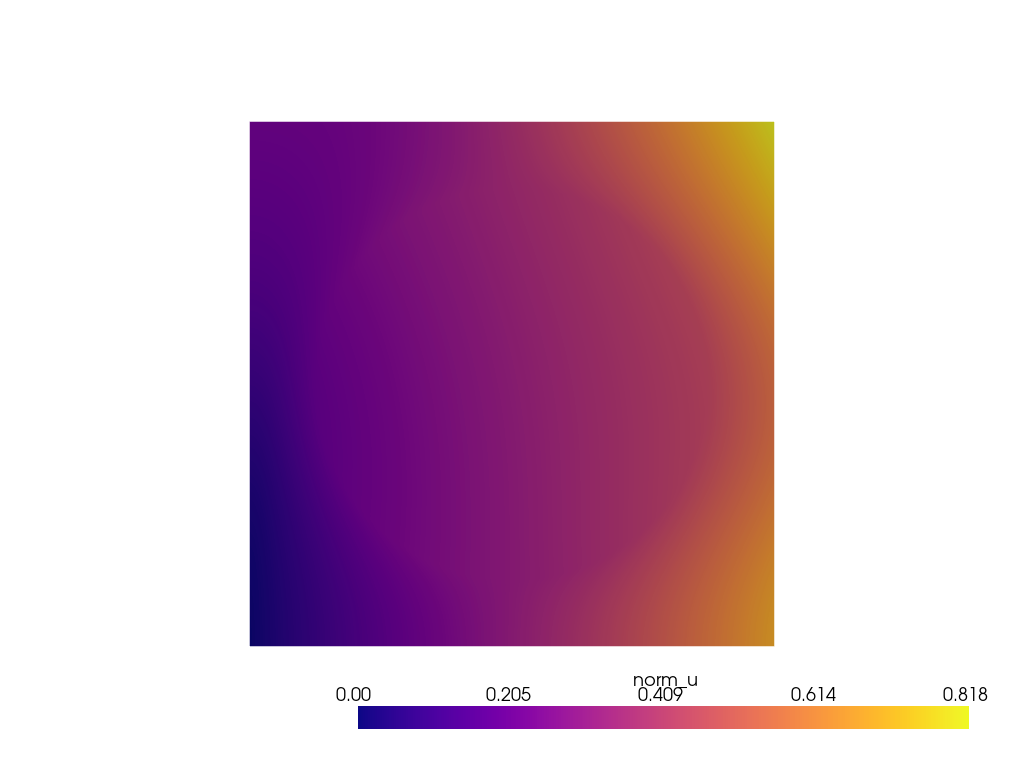

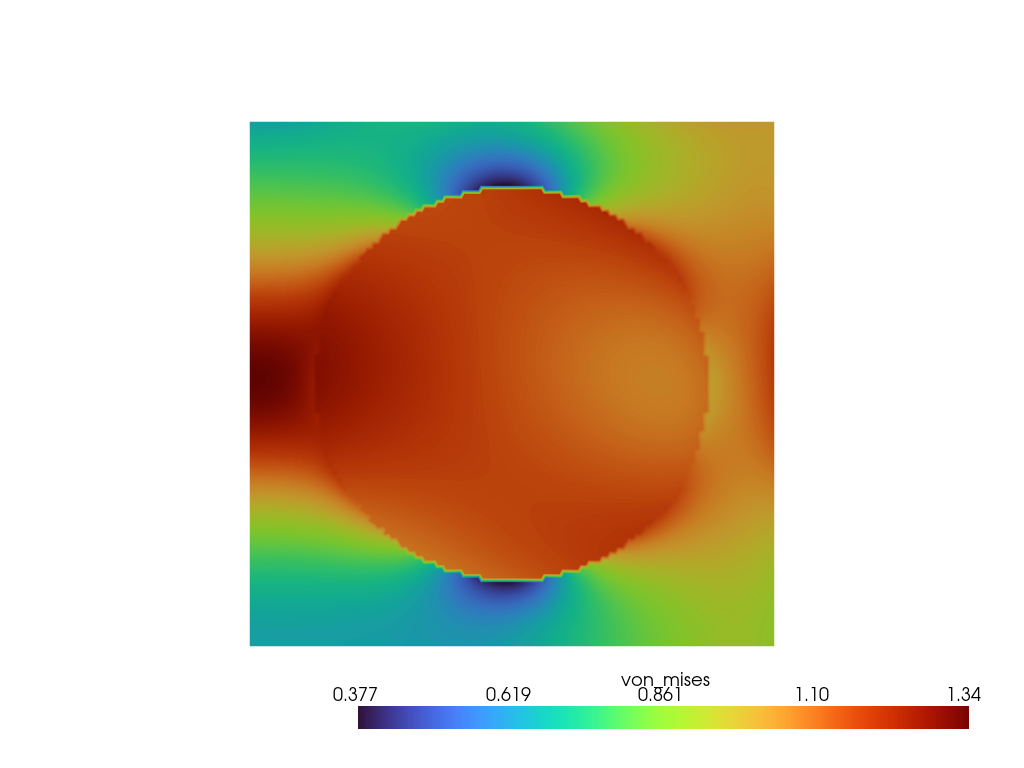

In [130]:
# pv.set_jupyter_backend('html')
visobj = pv.read("elastic_lin_2.vtu")

def save_png(field, filename, cmap="viridis"):
    pl = pv.Plotter(off_screen=True)
    pl.add_mesh(visobj, scalars=field, cmap=cmap, show_edges=False)
    pl.camera_position = "xy"
    pl.screenshot(filename)
    pl.close()

save_png("norm_u", "norm_u_2.png", cmap="plasma")
save_png("von_mises", "von_mises_2.png", cmap="turbo")

display(Image(filename="norm_u_2.png"))
display(Image(filename="von_mises_2.png"))